In [1]:
import torch
import torch.nn as nn
import numpy as np
from plotting import make_error_fig
from layers import StackedLinear
from dataset import generate_data, kernel

# Define the device etc
# torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [2]:
# Example for a larger dataset
epochs = 1000
batch_size = 200
n_samples = batch_size * 10
prior_width = 1
unc = 0.1
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

# get dataset load
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE),
    torch.tensor(y_train_scaled, dtype=DTYPE),
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Example for a larger dataset
hdn_dim = 32
channels = 100
beta = 1

model = nn.Sequential(
    StackedLinear(1, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, 2, channels),
)

opt = torch.optim.AdamW(
    model.parameters(), lr=5e-3, weight_decay=1 / (2 * len(x_train) * prior_width**2)
)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

for i in range(epochs):
    train_losses = np.array([])
    reg_losses = np.array([])
    for xb, yb in loader:
        h = model(xb[None, :, :].expand(channels, -1, -1))
        mu, log_sigma2 = h[:, :, 0], h[:, :, 1]

        # Heteroscedastic regression loss
        log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
        reg = 0.5 * ((yb[None, :] - mu) ** 2 / log_sigma2.exp() + log_sigma2)

        # ensemble loss
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean, dim=0)
        # repulsive interaction term
        k = kernel(reg, reg.detach())
        loss += beta * torch.sum(
            (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x_train), dim=0
        )

        train_losses = np.append(train_losses, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()

    train_losses_epoch = train_losses.mean()

    if i % 100 == 0:
        print(
            f"epoch={i}, loss={train_losses_epoch.item():.4f} "
            + f"reg-mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, "
            + f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}"
        )

epoch=0, loss=47.8922 reg-mean=0.3863, std=0.0317, min=0.3055, max=0.4555
epoch=100, loss=-55.6557 reg-mean=-0.5024, std=0.2593, min=-0.9915, max=0.1033
epoch=200, loss=-95.4470 reg-mean=-0.9374, std=0.1436, min=-1.1194, max=-0.3524
epoch=300, loss=-104.7988 reg-mean=-1.0423, std=0.1013, min=-1.1224, max=-0.4917
epoch=400, loss=-105.7153 reg-mean=-1.0535, std=0.0689, min=-1.1234, max=-0.5088
epoch=500, loss=-104.1007 reg-mean=-1.0842, std=0.0459, min=-1.1383, max=-0.7385
epoch=600, loss=-110.1130 reg-mean=-1.0642, std=0.0227, min=-1.1128, max=-0.9596
epoch=700, loss=-111.1248 reg-mean=-1.1577, std=0.0113, min=-1.1832, max=-1.1112
epoch=800, loss=-112.3913 reg-mean=-1.0584, std=0.0098, min=-1.0797, max=-1.0245
epoch=900, loss=-113.3069 reg-mean=-1.1169, std=0.0052, min=-1.1263, max=-1.0907


In [4]:
# plot prediction and error bands
# note: only the predictive error is shown
# (i.e. the error from limited training statistics, as extracted by the repulsive ensemble)
means = []
sigmas2 = []
xx = torch.linspace(-1.25, 1.25, 1000, dtype=DTYPE)
yy = (0.5 * torch.sin(23 * xx) + xx / 2).numpy()

with torch.no_grad():
    x_test = xx[None, :, None].expand(channels, -1, -1)
    h_test = model(x_test)
    mus, logsigma2 = h_test[:, :, 0], h_test[:, :, 1]
    log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
    sigma2 = logsigma2.exp()

means.append(mus.detach().cpu().numpy())
sigmas2.append(sigma2.detach().cpu().numpy())

mus = np.stack(means, axis=1) * Y_STD + Y_MEAN
sigmas2 = np.stack(sigmas2, axis=1)
sig = np.sqrt(sigmas2) * Y_STD

mean = np.squeeze(mus.mean(axis=0))
std = np.squeeze(mus.std(axis=0))
sigmean = np.squeeze(sig.mean(axis=0))

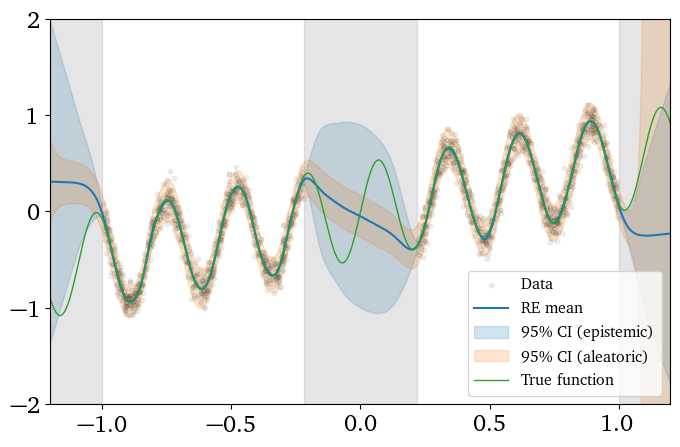

In [7]:
make_error_fig(
    data_train=(x_train, y_train),
    x_values=xx,
    y_mean=mean,
    y_std_epistemic=std,
    y_std_aleatoric=sigmean,
    network_name="RE",
)